In [12]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.metrics import r2_score
from tresboncoin.utils import km_per_year
import re

In [13]:
sns.set(rc={"figure.figsize":(12, 8)})
pd.set_option("display.max_columns", None)

# Import data

In [14]:
df = pd.read_csv('../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv')
print(df.shape)

(50007, 28)


# Cleaning and Feature engineering

In [15]:
# cleaning
df = df.drop_duplicates()
df = df[(df["bike_year"] >= (-df["bike_year"].std() * 3 + df["bike_year"].mean())) & (df["bike_year"] <= 2022)]
df = df[(df["mileage"] >= 1000) & (df["mileage"] <= (df["mileage"].mean() + 3 * df["mileage"].std()))]
df = df[(df["price"] >= 1000) & (df["price"] < (df["price"].mean() + 4 * df["price"].std()))]
df = df[(df["engine_size"] >= 49) & (df["engine_size"] < (df["engine_size"].mean() + 3 * df["engine_size"].std()))]
df = df[~df["category_db"].isnull()]
df = df[df["brand_db"].isin(list(pd.DataFrame(df["brand_db"].value_counts())[0:50].index))]

# feature engineering
df['km/year'] = df.apply(lambda x: km_per_year(x['mileage'], x['bike_year']), axis=1)

def return_bike_age(string_, bike_year):
    year = int(re.search(r'\d{4}', string_).group())
    return int(year - bike_year)

df['bike_age'] = df.apply(lambda x: return_bike_age(x.date_scrapped, x.bike_year), axis=1)

# remove duplicates
df.drop_duplicates(subset=['model_db', 'brand_db', 'price', 'mileage', 'bike_year'], inplace=True)

df = df[['brand_db', 'model_db', 'bike_year', "category_db", 'engine_size_db', 'mileage', 'km/year', 'bike_age', "price"]]
df.dropna(inplace=True)

# data size after
print("Data size after cleaning: " + str(df.shape))

data = df.copy()

Data size after cleaning: (24623, 9)


# Explore data

In [16]:
data.brand_db.nunique()

50

In [17]:
data.model_db.nunique()

1215

## Price
### vs mileage (km) per category

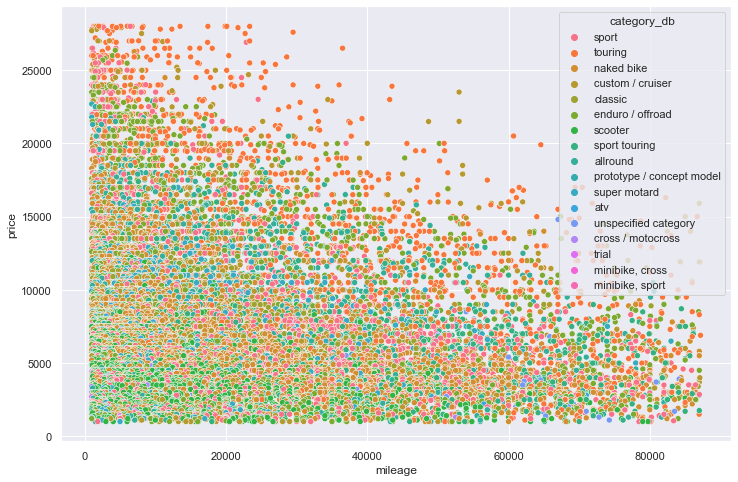

In [18]:
sns.scatterplot(x='mileage', y='price', hue='category_db', data=data);

### vs mileage (km) per engine size

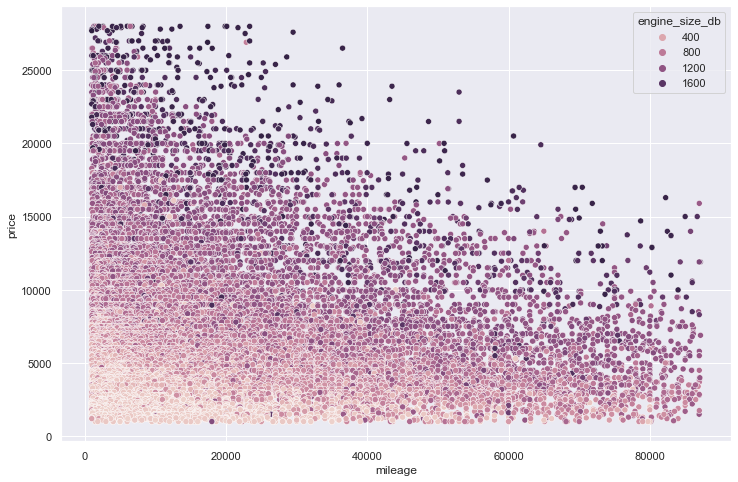

In [19]:
sns.scatterplot(x='mileage', y='price', hue='engine_size_db', data=data);

### vs year of release per category

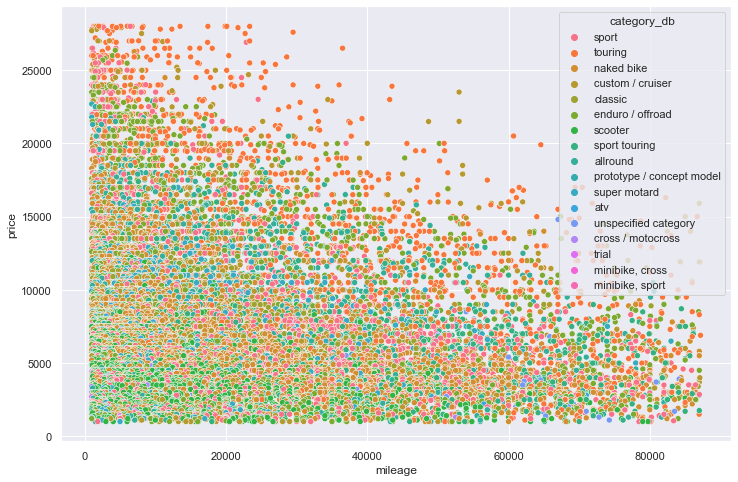

In [23]:
sns.scatterplot(x='mileage', y='price', hue='category_db',data=data);

### vs year of release per engine size

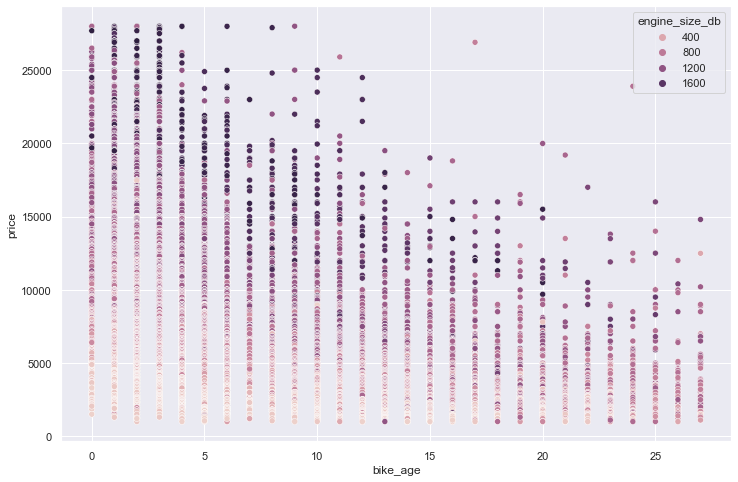

In [25]:
sns.scatterplot(x='bike_age', y='price', hue='engine_size_db', data=data);

### vs km/year

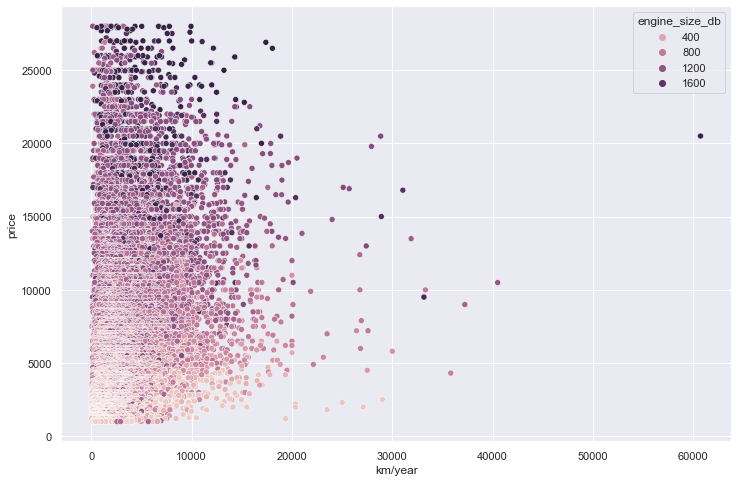

In [27]:
sns.scatterplot(x='km/year', y='price', hue='engine_size_db',data=data);

### Average price per engine size

In [28]:
data.groupby('engine_size_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
engine_size_db,,,
48.9,3059.666667,301.596309,3
49.0,2199.453333,1072.161536,75
49.1,1274.500000,34.648232,2
49.2,2381.200000,1906.554491,15
49.3,1988.090909,574.327011,22
...,...,...,...
1854.0,12279.000000,6287.165975,6
1868.0,24920.869565,2672.309034,23
1868.2,22267.000000,2780.925445,7


In [ ]:
#engine_size_count_threshold = 3
#groupby_engine_size = data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#groupby_engine_size[groupby_engine_size.Count < 4]
#groupby_engine_size

### Average price per category

In [ ]:
data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

In [ ]:
category_count_threshold = 200
groupby_category = data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_category = groupby_category[groupby_category .Count < category_count_threshold].index.to_list()
drop_category.append('unspecified category')

In [ ]:
data = data[data.category_db.isin(drop_category) == False]

### Average price per brand

In [ ]:
data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

In [ ]:
brand_count_threshold = 200
groupby_brand = data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_brand = groupby_brand[groupby_brand.Count < brand_count_threshold].index.to_list()
data = data[data.brand_db.isin(drop_brand) == False]

### Average price per model

In [ ]:
data.groupby(['brand_db','model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

In [ ]:
#model_count_threshold = 1
#groupby_model = data.groupby(['model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
#data = data[data.model_db.isin(drop_model) == False]

## Correlation matrix

In [ ]:
sns.heatmap(data.corr(), annot = True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

# BASELINE

## Average

In [29]:
from sklearn.metrics import r2_score

# mean
average_price = data.price.mean()

#rmse
rmse_baseline = np.sqrt(sum((data['price']-average_price)**2)/((data['price'].count())))

print("Average price :", average_price)
print("RMSE Baseline", rmse_baseline )

# r  square
data['y_pred'] = average_price
r2 = r2_score(data.price, data.y_pred)
print("R^2", r2 )

Average price : 7813.577346383463
RMSE Baseline 5056.327411225586
R^2 0.0


## Average per year

In [30]:
average_year = data.groupby(['bike_year']).agg(Mean=('price', 'mean'))

In [31]:
def mean_year(year):
    return average_year[average_year.index == year].max()

data['y_pred2'] = data.bike_year.apply(mean_year)

In [32]:
#rmse
rmse_baseline_2 = np.sqrt(sum((data['price']-data.y_pred2)**2)/((data['price'].count())))

print("RMSE Baseline 2", rmse_baseline_2 )

# r  square
r2 = r2_score(data.price, data.y_pred2)
print("R^2", r2 )

RMSE Baseline 2 4445.204734593134
R^2 0.22711805759147707


## Average  per year and brand

In [33]:
average_year_brand = data.groupby(['brand_db','bike_year']).agg(Mean=('price', 'mean'))

In [34]:
def mean_year_brand(year, brand):
    return average_year_brand[average_year_brand.index  == (brand, year)].max()

data['y_pred3'] = data.apply(lambda x:mean_year_brand(x.bike_year, x.brand_db), axis=1)

In [35]:
#rmse
rmse_baseline_3 = np.sqrt(sum((data['price']-data.y_pred3)**2)/((data['price'].count())))

print("RMSE Baseline 2", rmse_baseline_3 )

# r  square
r2 = r2_score(data.price, data.y_pred3)
print("R^2", r2 )

RMSE Baseline 2 3394.3571658468354
R^2 0.5493444740629059


# LINEAR REGRESSION

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

## Numerical features (not scaled)

In [37]:
data_1 = data.copy()
data_1.shape

(24623, 12)

In [38]:
features_1 = ['bike_age', 'mileage', 'km/year', 'engine_size_db']

In [39]:
for feature in features_1:
    data_1.dropna(subset=[feature],inplace=True)
data_1.shape  

(24623, 12)

In [46]:
X = data_1[features_1]
y = data_1['price']

model_1 = LinearRegression()

cv_results = cross_validate(model_1, X, y, cv=2)
cv_results['test_score'].mean()

0.667157278513361

## Numerical features (not scaled) + brand encoded

In [49]:
data_2 = data.copy()[['brand_db', 'bike_age', 'mileage', 'engine_size_db', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand_db']])

feature_encoded = ohe.transform(data_2[['brand_db']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand_db', 'price'])
y = data_2['price']

model_2 = LinearRegression()

cv_results = cross_validate(model_2, X, y, cv=2)
cv_results['test_score'].mean()

0.6926387205394455

# KNR

## KNeighborsRegressor - Numerical features (not scaled) + brand encoded

In [50]:
data_2 = data.copy()[['brand_db', 'bike_age', 'mileage', 'engine_size_db', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand_db']])

feature_encoded = ohe.transform(data_2[['brand_db']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand_db', 'price'])
y = data_2['price']

In [51]:
model_3 = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(model_3, X, y, cv=2)
cv_results['test_score'].mean()

0.4989826153576328

## KNeighborsRegressor - Numerical features (scaled) + brand encoded

### Brand

### Category

In [53]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['category_db','brand_db', 'bike_age','mileage','engine_size_db','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['bike_age','mileage','engine_size_db','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=2, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

r2 0.6557642600400525
RMSE -2738.270374619992


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

### Brand and category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

# PIPELINE

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import set_config

set_config(display='diagram')

## Pipeline Baseline

### Category

In [ ]:
data_1=data.copy()[['age','mileage','engine_size','km/year', 'category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year', 'category_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

### Brand

In [ ]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

### Brand & Category

In [ ]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db','category_db',]] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

## Pipeline gridsearch

In [ ]:
# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe, 
    param_grid={
        'preprocessing__num_transformer__scaler': [StandardScaler()], #MinMaxScaler(), RobustScaler(), 
        'KNeighborsRegressor__n_neighbors': list(range(9,13)),
        #'KNeighborsRegressor__leaf_size': [1,2,3],
        'KNeighborsRegressor__metric': ['euclidean',
                                        'manhattan'],
        'KNeighborsRegressor__weights': ['uniform', 'distance']},
    cv=3,
    scoring=['r2', 'neg_root_mean_squared_error'],
    refit='r2')

grid_search.fit(X_1, y_1)
print("best_params",grid_search.best_params_)
print("best_score",grid_search.best_score_)

In [ ]:
print(grid_search.score(X_1,y_1))
print(final_pipe_trained.score(X_1,y_1))

In [ ]:
grid_search.cv_results_

## Optimized Pipeline

In [ ]:
num_transformer = Pipeline([('scaler', grid_search.best_params_['preprocessing__num_transformer__scaler'])])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and Regression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor(
        #leaf_size=grid_search.best_params_['KNeighborsRegressor__leaf_size'],
        metric=grid_search.best_params_['KNeighborsRegressor__metric'], 
        n_neighbors=grid_search.best_params_['KNeighborsRegressor__n_neighbors'], 
        weights=grid_search.best_params_['KNeighborsRegressor__weights']))])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(final_pipe, X_1, y_1, cv=3, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

## Prediction

In [ ]:
X_pred = pd.DataFrame([[10,5000,800,1000,'bmw']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])

In [ ]:
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[4,2347,1200,586,'triumph']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[6,26500,990,4416,'ktm']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

# Optimisé pour les modèles

In [ ]:
model_count_threshold = 200
groupby_model = data.groupby('model_db').agg(Mean=('price', 'mean'), Count=('price', 'count'))
drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
data_model = data[data.model_db.isin(drop_model) == False]

In [ ]:
data_1=data_model.copy()[['age','mileage','km/year', 'model_db','price', 'engine_size']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','km/year', 'model_db', 'engine_size']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','km/year','engine_size']) ,
    ('cat_transformer',cat_transformer , ['model_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

In [ ]:
X = data_1[['age','mileage','km/year', 'model_db', 'engine_size']]
y = data_1['price']

cv_results = cross_validate(final_pipe, X, y, cv=3)
cv_results['test_score'].mean()

In [ ]:
data_model.shape

In [ ]:
data